In [50]:
import numpy as np

In [51]:
def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [52]:
def cross_entropy_error(y, t):
    delta = 1e-7 #logの中身が0にならないようにするための微小値
    return -np.sum(t * np.log(y + delta))

In [53]:
%cd ./deep-learning-from-scratch-master/


[Errno 2] No such file or directory: './deep-learning-from-scratch-master/'
/Users/macowner/Documents/Programming/0tsuku/deep-learning-from-scratch-master


In [54]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape) # (60000, 784)
print(t_train.shape) # (60000, 10)

(60000, 784)
(60000, 10)


In [55]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]


In [56]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [57]:
def numerical_diff(f, x): #微分
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

In [58]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列を生成

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元に戻す

    return grad

In [59]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x  = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x

In [60]:
def function_2(x):
    return x[0]**2+x[1]**2

init_x=np.array([-3.0,4.0])
gradient_descent(function_2,init_x=init_x,lr=0.000001,step_num=1000)

array([-2.99400599,  3.99200799])

In [61]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax,cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [62]:
net=simpleNet()
print(net.W)

[[ 1.34648715  1.97670474 -0.48814948]
 [ 0.85412294  0.04724501  1.24023853]]


In [63]:
x=np.array([0.6,0.9])
p=net.predict(x)
p

array([1.57660294, 1.22854336, 0.82332499])

In [64]:
np.argmax(p)

0

In [65]:
t=np.array([0,0,1])
net.loss(x,t)

1.5311689999606763

In [66]:
def f(W):
    return net.loss(x,t)

dW = numerical_gradient(f, net.W)
dW

array([[ 0.27562402,  0.19460621, -0.47023023],
       [ 0.41343603,  0.29190932, -0.70534535]])

In [67]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [73]:
import numpy as np
from dataset.mnist import load_mnist
# from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# ハイパーパラメータ
iters_num = 100
train_size = x_train.shape[0]
batch_size = 10
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版!

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


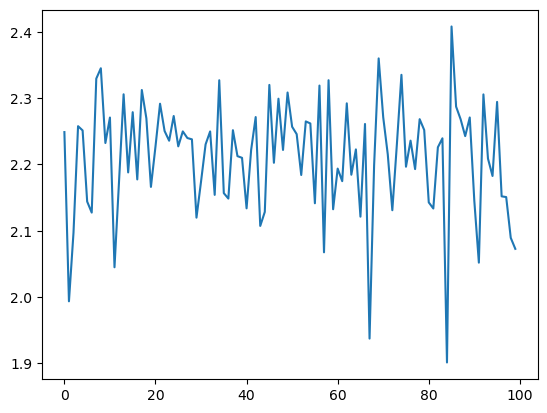

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss_list)
plt.show()

In [75]:
import numpy as np
from dataset.mnist import load_mnist
# from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []
# 1エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)

# ハイパーパラメータ
iters_num = 100
train_size = x_train.shape[0]
batch_size = 5
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版!

    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    print(i)
    # 1エポックごとに認識精度を計算
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

0
train acc, test acc | 0.09863333333333334, 0.0958
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


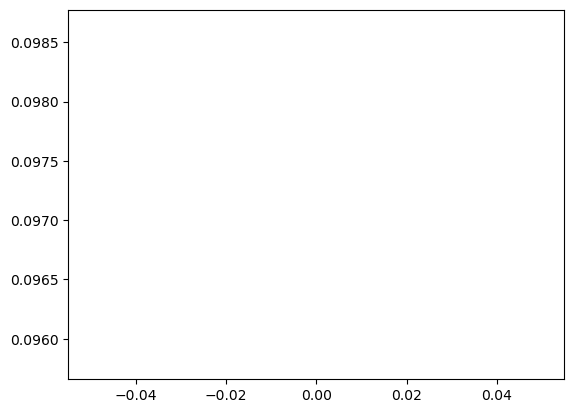

In [76]:
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.show()

In [77]:
train_acc_list

[0.09863333333333334]